<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch6-TD_Learning/WindyGridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
%matplotlib inline

## Windy Grid

This is the solution to Exercise-6.5 in Page-130 of the book ["Reinforcement Learning" by Barto, Sutton](http://incompleteideas.net/sutton/book/the-book.html).

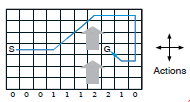

The summary of the problem is as follows:
1. Given the grid above, we need to find an optimal path from the start 'S' to the goal 'G' using the SARSA algorithm.
2. The grid also has a wind blowing from the bottom to the top. The speed of the wind serves to push the path in its direction by the intensity shown at the bottom of the grid above.
3. The first part of the problem focusses on finding a path using only horizontal & vertical moves as allowed actions.
4. The second part of the problem allows diagonal moves as part of the actions set.
5. The third part of the problem allows no moves in addition to the King's moves in Step-4 above.

In [2]:
grid_rows = 7
grid_cols = 10
start = [3,0]
goal  = [3,7]
hv_actions = [[-1,0],[0,1],[1,0],[0,-1]]

In [3]:
def getWind(pos):
  if pos[1] < 3 or pos[1] >= 9:
    return [0,0]
  elif pos[1] in [6,7]:
    return [-2,0]
  return [-1,0]

def getPossibleActions(actions,pos):
  new_pos = [[pos[0]+a[0],pos[1]+a[1]] for a in actions]
  act_idx = [i for i in range(len(actions)) if new_pos[i][0] in range(grid_rows) and new_pos[i][1] in range(grid_cols)]
  return np.array(act_idx)

def target_policy(Q,epsilon,actions,pos):
  idx = getPossibleActions(actions,pos)#np.where(Q[pos[0],pos[1],:] != -np.inf)[0]#
  if epsilon > 0:
    random_action_flag = np.random.choice([False,True],p=[1-epsilon,epsilon])
    if random_action_flag:
      choice = np.random.choice(idx)
      return np.random.choice(idx)
  return idx[np.argmax(Q[pos[0],pos[1],idx])]
  # maxQ = np.max(Q[pos[0],pos[1],idx])
  # best_actions = idx[np.where(Q[pos[0],pos[1],idx] == maxQ)[0]]
  # choice = np.random.choice(best_actions)
  # return choice

def play_back(Q,actions):
  pos = start
  traj = []
  while pos[0] != goal[0] or pos[1] != goal[1]:
    act_idx = target_policy(Q,0.0,actions,pos)
    a = actions[act_idx]
    traj += [pos+[act_idx]]
    wind = getWind(pos)
    pos = [pos[0]+a[0]+wind[0],pos[1]+a[1]+wind[1]]
    pos = [max(0,min(grid_rows-1,pos[0])),max(0,min(grid_cols-1,pos[1]))]
    print(pos)
  return traj

def init_Q(actions):
  Q = np.zeros((grid_rows,grid_cols,len(actions)))
  for i in [0,grid_rows-1]:
    for j in range(grid_cols):
      for ia,a in enumerate(actions):
        if i+a[0] not in range(grid_rows) or j+a[1] not in range(grid_cols):
          Q[i,j,ia] = -np.inf
  for j in [0,grid_cols-1]:
    for i in range(grid_rows):
      for ia,a in enumerate(actions):
        if i+a[0] not in range(grid_rows) or j+a[1] not in range(grid_cols):
          Q[i,j,ia] = -np.inf
  return Q

def SARSA(num_episodes,actions,epsilon,alpha,gamma):
  Q = init_Q(actions)
  stats = []
  steps = 0
  for episode in tqdm(range(num_episodes)):
    pos = start
    S = pos
    init = True
    traj = []
    while pos[0] != goal[0] or pos[1] != goal[1]:
      steps += 1
      act_idx = target_policy(Q,epsilon,actions,pos)
      a = actions[act_idx]
      traj += [pos+[act_idx]]
      wind = getWind(pos)
      if init:
        init = False
        continue
      old_state = traj[-2]
      Q[old_state[0],old_state[1],old_state[2]] += alpha*(-1 + gamma*Q[pos[0],pos[1],act_idx] - Q[old_state[0],old_state[1],old_state[2]])
      pos = [pos[0]+a[0]+wind[0],pos[1]+a[1]+wind[1]]
      pos = [max(0,min(grid_rows-1,pos[0])),max(0,min(grid_cols-1,pos[1]))]
    stats += [[episode-1,steps,len(traj)]]
  return Q,np.array(stats)

def plot_grid(ax,traj):
  # create discrete colormap
  cmap = colors.ListedColormap(['white','red','blue','green'])
  bounds = [0,0.1,3]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  map = np.zeros((grid_rows,grid_cols))
  map[start[0],start[1]] = 1
  map[goal[0],goal[1]] = 3
  for i,t in enumerate(traj):
    if i == 0:
      continue
    map[t[0],t[1]] = 2
  ax.imshow(map, cmap=cmap)#, norm=norm)
  ### draw gridlines
  # ax = plt.gca();
  ax.set_xticks(np.arange(-0.5, grid_cols+0.5, 1));
  ax.set_yticks(np.arange(-0.5, grid_rows+0.5, 1));
  ax.set_xticklabels(np.arange(-0.5, grid_cols+0.5, 1));
  ax.set_yticklabels(np.arange(-0.5, grid_rows+0.5, 1));
  ax.grid(color='k', linestyle='-', linewidth=1)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

In [4]:
num_episodes = 1000
alpha = 0.5
gamma = 1
epsilon = 0.1
np.random.seed(0)
Q,stats = SARSA(num_episodes,hv_actions,epsilon,alpha,gamma)

100%|██████████| 1000/1000 [00:01<00:00, 777.37it/s]


In [5]:
pos = [6,1]#start
print(Q[pos[0],pos[1],:])
print(hv_actions[np.argmax(Q[pos[0],pos[1],:])])
print(stats.shape)

[-17.40129969 -16.79201691         -inf -17.22228367]
[0, 1]
(1000, 3)


[3, 1]
[2, 1]
[2, 2]
[2, 3]
[1, 4]
[0, 5]
[0, 6]
[0, 7]
[0, 8]
[0, 9]
[1, 9]
[2, 9]
[3, 9]
[4, 9]
[4, 8]
[3, 7]
Trajectory: 16
[[3, 0, 1], [3, 1, 0], [2, 1, 1], [2, 2, 1], [2, 3, 1], [1, 4, 1], [0, 5, 1], [0, 6, 1], [0, 7, 1], [0, 8, 1], [0, 9, 2], [1, 9, 2], [2, 9, 2], [3, 9, 2], [4, 9, 3], [4, 8, 3]]


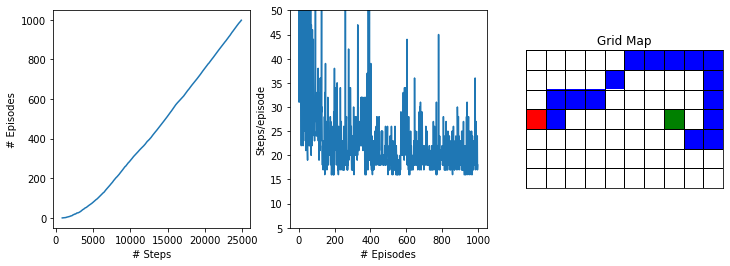

In [6]:
traj = play_back(Q,hv_actions)
print('Trajectory:',len(traj))
print(traj)
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(stats[:,1],stats[:,0])
ax[0].set_xlabel('# Steps')
ax[0].set_ylabel('# Episodes')
ax[1].plot(stats[:,0],stats[:,2])
ax[1].set_ylabel('Steps/episode')
ax[1].set_xlabel('# Episodes')
ax[1].set_ylim([5,50])
plot_grid(ax[2],traj)
ax[2].set_title('Grid Map');

In [7]:
kings_moves = hv_actions + [[-1,-1],[-1,1],[1,-1],[1,1]]
# np.random.seed(0)
Q_kings,stats_kings = SARSA(num_episodes,kings_moves,epsilon,alpha,gamma)

100%|██████████| 1000/1000 [00:00<00:00, 1171.40it/s]


In [8]:
pos = start
print(Q_kings[pos[0],pos[1],:])

[-11.26972989  -7.67855775 -11.74300729         -inf         -inf
 -10.96800457         -inf -10.71524987]


[3, 1]
[3, 2]
[4, 3]
[4, 4]
[4, 5]
[4, 6]
[3, 7]
Trajectory: 7
[[3, 0, 1], [3, 1, 1], [3, 2, 7], [4, 3, 7], [4, 4, 7], [4, 5, 7], [4, 6, 7]]


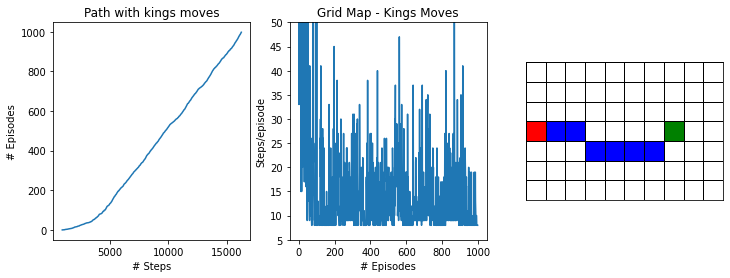

In [9]:
traj_kings = play_back(Q_kings,kings_moves)
print('Trajectory:',len(traj_kings))
print(traj_kings)
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(stats_kings[:,1],stats_kings[:,0])
ax[0].set_xlabel('# Steps')
ax[0].set_ylabel('# Episodes')
ax[0].set_title('Path with kings moves')
ax[1].plot(stats_kings[:,0],stats_kings[:,2])
ax[1].set_ylabel('Steps/episode')
ax[1].set_xlabel('# Episodes')
ax[1].set_ylim([5,50])
plot_grid(ax[2],traj_kings)
ax[1].set_title('Grid Map - Kings Moves');

In [10]:
kings_wStationary = kings_moves + [[0,0]]
# np.random.seed(0)
Q_stationary,stats_stationary = SARSA(num_episodes,kings_wStationary,epsilon,alpha,gamma)

100%|██████████| 1000/1000 [00:00<00:00, 1121.87it/s]


In [11]:
pos = start
print(Q_stationary[pos[0],pos[1],:])

[-10.60480642  -6.79056829 -10.41716493         -inf         -inf
 -10.4002057          -inf -10.38037473 -10.50348246]


[3, 1]
[4, 2]
[5, 3]
[5, 4]
[5, 5]
[5, 6]
[3, 7]
Trajectory Length: 7
[[3, 0, 1], [3, 1, 7], [4, 2, 7], [5, 3, 7], [5, 4, 7], [5, 5, 7], [5, 6, 1]]


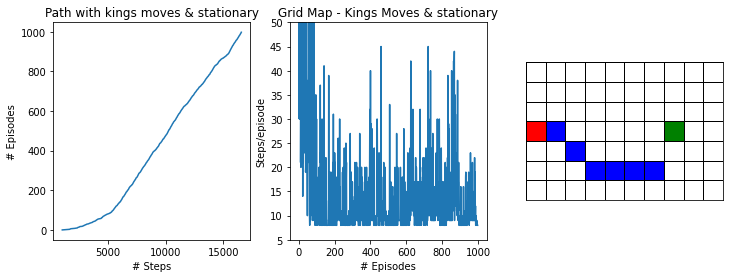

In [12]:
traj_stationary = play_back(Q_stationary,kings_wStationary)
print('Trajectory Length:', len(traj_stationary))
print(traj_stationary)
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(stats_stationary[:,1],stats_stationary[:,0])
ax[0].set_xlabel('# Steps')
ax[0].set_ylabel('# Episodes')
ax[0].set_title('Path with kings moves & stationary')
ax[1].plot(stats_stationary[:,0],stats_stationary[:,2])
ax[1].set_ylabel('Steps/episode')
ax[1].set_xlabel('# Episodes')
ax[1].set_ylim([5,50])
ax[0].set_title('Path with kings moves & stationary')
plot_grid(ax[2],traj_stationary)
ax[1].set_title('Grid Map - Kings Moves & stationary');